## Train model - Experiments

In [1]:
!pip install keras

* U-Net architecture

In [2]:
from keras.models import *
from keras.layers import *
from keras import backend as keras
from keras.utils import plot_model
keras.clear_session()

def unet(input_size = (512, 512, 1)):
    def jaccard_distance_loss(y_true, y_pred, smooth=1):
        intersection = K.sum(y_true * y_pred)
        sum_ = K.sum(y_true + y_pred)
        jac = (intersection + smooth) / (sum_ - intersection + smooth)
        return (1 - jac)
    def iou(y_true, y_pred, smooth=1):
        intersection = K.sum(y_true * y_pred)
        union = K.sum(y_true) + K.sum(y_pred) - intersection
        iou = (intersection + smooth) / ( union + smooth)
        return iou
    inputs = Input(input_size)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same')(pool2)
    up1 = UpSampling2D(size = (2, 2))(conv3)
    merge1 = concatenate([conv2, up1], axis = 3)
    conv4 = Conv2D(32, 3, activation = 'relu', padding = 'same')(merge1)
    up2 = UpSampling2D(size = (2, 2))(conv4)
    merge2 = concatenate([conv1, up2], axis = 3)
    conv5 = Conv2D(16, 3, activation = 'relu', padding = 'same')(merge2)
    output = Conv2D(1, 3, activation = 'sigmoid', padding = 'same')(conv5)
    model = Model(inputs, output)
    model.compile(optimizer = 'adam', loss = jaccard_distance_loss, metrics = [iou])
    return model

* Load dataset - failed attempt to load directly in RAM

In [3]:
images_dir = '../chronsite_images/images/'
masks_dir = '../chronsite_images/masks/'

import glob
import os
images = glob.glob(os.path.join(images_dir,'*.jpg')) # list images
masks = glob.glob(os.path.join(masks_dir, '*.png')) # list masks
images.sort()
masks.sort()

In [ ]:
X_train = []
from tqdm.notebook import tqdm
for idx, 

In [ ]:
Y_train = []
for f in next(os.walk(mask_dir))[2]:
    if f.startswith(info["id"]):
        m = skimage.io.imread(os.path.join(mask_dir, f)).astype(np.bool)
        mask.append(m)
mask = np.stack(mask, axis=-1)

In [ ]:
image = skimage.io.imread(self.image_info[image_id]['path'])

* Data augmentation generators - failed attempts with `keras.preprocessing.image` and with the `ImageDataAugmentor` library

In [4]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor
!pip install albumentations

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-p0vt_bfp
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=28028 sha256=86f5c4ccd0298a2fd616deca5a7195e2b211279409c46be65e2d150ad9f6c6b7
  Stored in directory: /tmp/pip-ephem-wheel-cache-j5xlnmiv/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor


<br>
Make sure that all augmentations are meaningful for both image and mask generation (e.g. no noise augmentations for masks!) and remember to call .to_deterministic() to ensure that both the images and the mask are augmented with same transformations.

In [5]:
# with albumentations and ImageDataAugmentor

from ImageDataAugmentor.image_data_augmentor import *
import albumentations

# define augmentations
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    #albumentations.ElasticTransform()
])

# create one generator for images and one for masks, with flow_from_directory
img_data_gen = ImageDataAugmentor(augment=AUGMENTATIONS, augment_seed=123)
img_gen = img_data_gen.flow_from_directory('../chronsite_images/images/', class_mode=None, shuffle=True, seed=123)
mask_data_gen = ImageDataAugmentor(augment=AUGMENTATIONS, augment_seed=123, augment_mode='mask')
mask_gen = mask_data_gen.flow_from_directory('../chronsite_images/masks/', class_mode=None, shuffle=True, seed=123)

# combine generators into one which yields image and masks
train_gen = zip(img_gen, mask_gen)

Found 1 images belonging to 1 classes.
Found 7 images belonging to 1 classes.


In [6]:
# with the regular keras preprocessing pipeline
from keras.preprocessing.image import *

# we create two instances with the same arguments
data_gen_args = dict(#featurewise_center=True,
                     #featurewise_std_normalization=True,
                     #brightness_range=(0.8,1),
                     #zoom_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
#image_datagen.fit(images, augment=True, seed=seed)
#mask_datagen.fit(masks, augment=True, seed=seed)
image_generator = image_datagen.flow_from_directory(
    '../chronsite_images',
    class_mode=None,
    seed=seed,
    classes=['images'],
target_size=(500, 500))
mask_generator = mask_datagen.flow_from_directory(
    '../chronsite_images',
    class_mode=None,
    seed=seed,
    classes=['masks'],
target_size=(500, 500))

# combine generators into one which yields image and masks
train_gen = zip(image_generator, mask_generator)

Found 1583 images belonging to 1 classes.
Found 3171 images belonging to 1 classes.


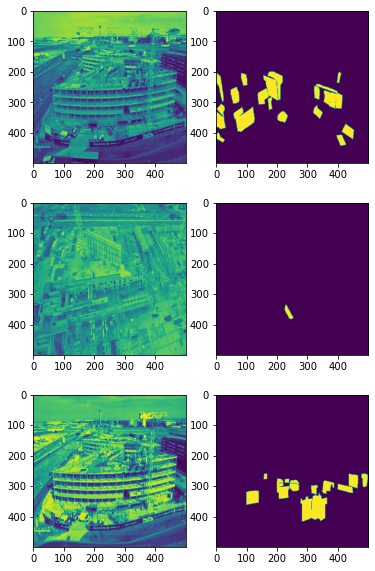

In [11]:
# Visualize images
import matplotlib.pyplot as plt
k = 3
image_batch, mask_batch = next(train_gen)
fix, ax = plt.subplots(k,2, figsize=(k*2,10))
for i in range(k):
    ax[i,0].imshow(image_batch[i,:,:,0])
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [ ]:
# fit the keras model
model.fit(
    train_gen,
    steps_per_epoch=2000,
    epochs=50)

* Training